# How are the study tiles clustered in the embedding space?

In this notebook you will work with 1000 embedding vectors (with length `100`) produced for a *study* dataset of 1000 tiles. The aim is to answer questions like:

1. Are there are finite number of distinct clusters of tiles in the embedding space?

2. How do different clustering algorithms work and what insight can they give us?

As time permits the examples below give some suggestions on how to explore the embedding space using:

- [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means): number of clusters is parameter, not guaranteed to exist inside of each other as number of clusters is increased
- [Hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering): number of clusters is parameter, clusters sub-devided as number of clusters is increased

- [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS): density-based clustering, number of clusters is not prescribed

You are also very welcome to pick a [different clustering algorithm](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) from scikit-learn

Note: Although all the analysis in this notebook can be carried out without installing `convml_tt` (and all its dependencies) the plotting routines in there make it easier to visiualise the tiles you will be looking at.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import convml_tt

xr.__version__, convml_tt.__version__

('0.15.0', '0.5.0')

In [2]:
tileset_path = Path('../Nx256_s200000.0_N500study_pretrained')

In [3]:
da_emb = xr.open_dataarray(tileset_path/'fixednorm-stage-2.emb.nc')
da_emb.attrs['source_path'] = tileset_path/'study'
# the values are quite small, so let's scale them a bit
# (could instead retrain the model with a loss function that encourages larger values)
da_emb.values = 1.0e4 * da_emb.values
da_emb

<xarray.DataArray (tile_id: 1000, emb_dim: 100)>
array([[ 4.439113e-01, -8.988900e-03,  1.845036e-02, -6.016446e-02, ..., -5.035645e-01,  3.415524e-02, -1.882763e-01,
         3.102875e-01],
       [ 3.746718e-01, -3.905472e-02, -1.944061e-01, -3.712340e-01, ...,  2.646773e-01,  4.308116e-01, -4.589656e-01,
        -1.901568e-02],
       [ 2.817766e-01, -7.063743e-02,  2.045486e-01, -7.083338e-01, ...,  1.590397e-02, -3.190878e-01,  3.008851e-01,
         3.694958e-01],
       [-1.683713e-01,  1.758206e-02, -1.116556e-01,  1.495027e-03, ..., -8.979005e-02, -1.175369e-02, -1.817017e-01,
         2.149013e-01],
       ...,
       [ 5.112088e-04, -6.799819e-02,  1.441675e-01, -3.055122e-01, ...,  3.676909e-02, -5.180820e-02,  5.576241e-01,
         2.163367e-01],
       [-2.969494e-01, -2.210941e-01, -1.465371e-01,  2.636585e-01, ...,  2.662880e-02,  6.221555e-02, -1.242121e-01,
        -1.289532e-01],
       [-2.552627e-01, -1.335888e-01, -1.621911e-01,  3.476777e-01, ...,  3.210507e-01,  1.623332e-01,  9.913253e-02,
        -1.937438e-01],
       [-4.033427e-02, -8.829302e-02,  2.456995e-02, -3.113366e-02, ...,  4.204030e-02,  1.894077e-02, -1.943776e-01,
         1.783152e-01]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * emb_dim  (emb_dim) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    source_path:  ../Nx256_s200000.0_N500study_pretrained/study
    tile_used:    anchor

## 1. K-means clustering

In [4]:
from sklearn.cluster import KMeans

In [5]:
# run KMeans clustering with a fixed number of clusters
kmeans = KMeans(n_clusters=5, random_state=0)

kmeans.fit_transform(da_emb)

# create an xarray.DataArray to make this array easier to work with
da_kmeans = xr.DataArray(
    kmeans.labels_,
    dims=('tile_id', ),
    coords=dict(tile_id=da_emb.tile_id)
)
da_kmeans

<xarray.DataArray (tile_id: 1000)>
array([3, 0, 1, 3, ..., 1, 3, 2, 3], dtype=int32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

<BarContainer object of 5 artists>

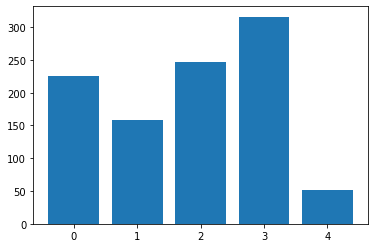

In [6]:
# how many are there in each cluster?
plt.bar(*np.unique(da_kmeans, return_counts=True))

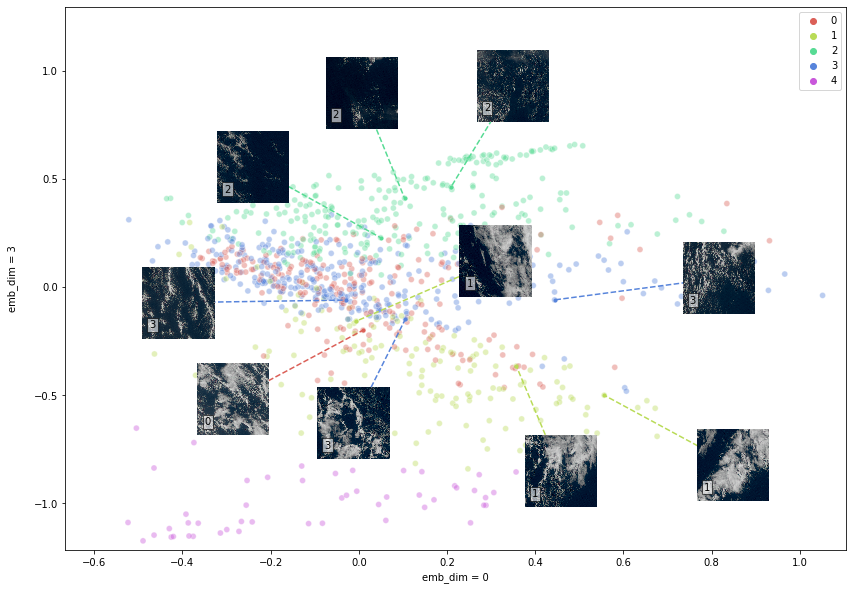

In [7]:
# plot the first two embedding dimensions against each other, annotated with 10 random tiles

fig, ax = plt.subplots(figsize=(14, 10))
x = da_emb.sel(emb_dim=0)
y = da_emb.sel(emb_dim=3)

_ = convml_tt.interpretation.plots.scatter_annotated(x, y, points=10, ax=ax, hue=da_kmeans, hue_palette='hls')

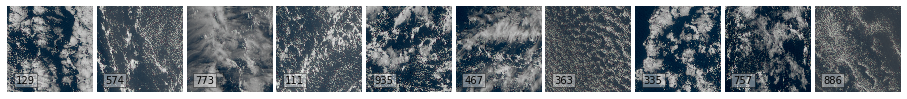

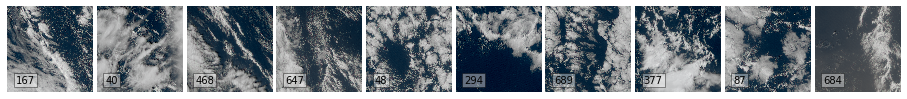

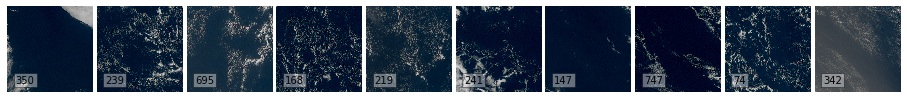

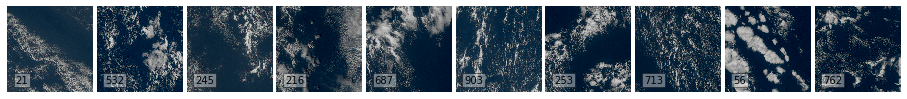

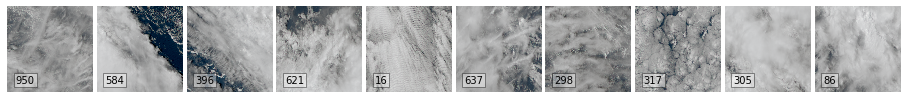

In [8]:
# plot 10 examples from each cluster
triplets = convml_tt.NPMultiImageList.from_folder(da_emb.source_path)

for n in np.unique(da_kmeans):
    idxs = np.random.choice(da_kmeans.where(da_kmeans == n, drop=True).tile_id, 10)
    convml_tt.interpretation.plots.grid_overview(triplets=triplets, points=idxs)

## 2. Hierarchical clustering

Although the hierarchical clustering below uses the methods in scikit-learn I created my own routine to produce a dendrogram with tile examples below. You may simply use `sklearn.cluster.AgglomerativeClustering` directly (in a similar way to how `KMeans` was used above) and skip making a dendrogram.

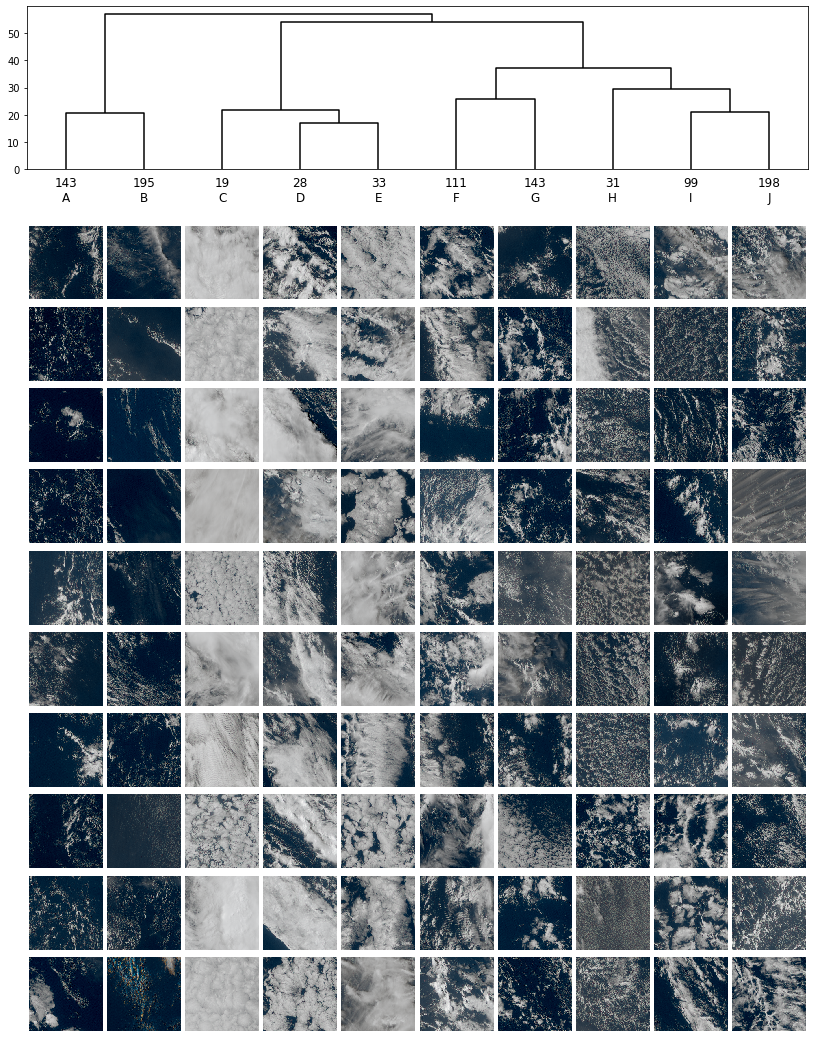

In [9]:
# make a dendrogram plot
_, arr_clusters = convml_tt.interpretation.plots.dendrogram(da_emb, return_clusters=True, label_clusters=True,
                                                            n_clusters_max=10)

In [10]:
# create an xarray.DataArray to make this array easier to work with
da_hierc = xr.DataArray(
    arr_clusters,
    dims=('tile_id', ),
    coords=dict(tile_id=da_emb.tile_id)
)
da_hierc

<xarray.DataArray (tile_id: 1000)>
array(['G', 'I', 'F', 'J', ..., 'F', 'A', 'A', 'I'], dtype='<U1')
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

<BarContainer object of 10 artists>

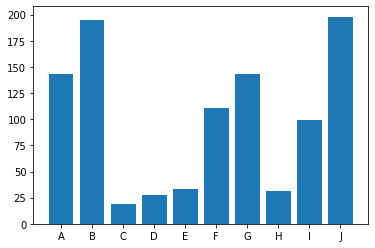

In [11]:
# how many tiles are there in each cluster?
plt.bar(*np.unique(da_hierc, return_counts=True))

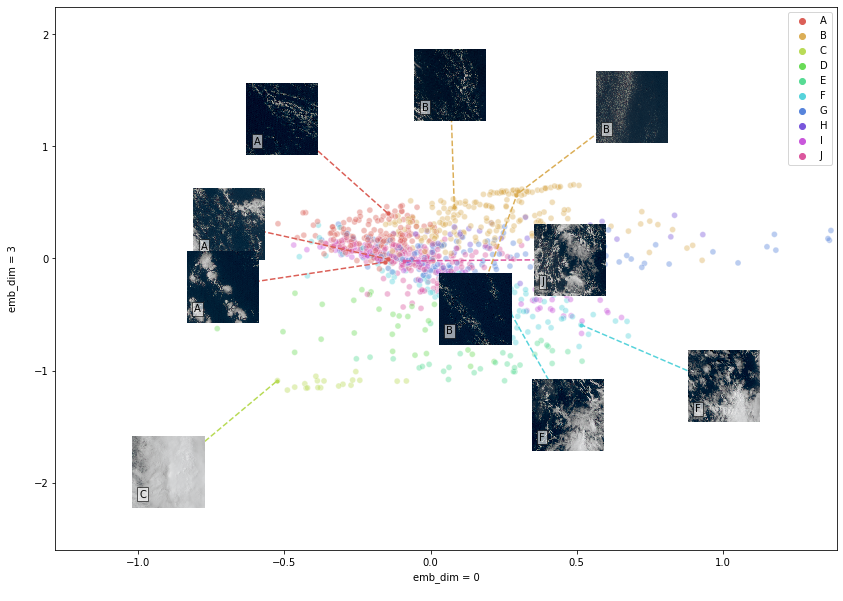

In [12]:
# plot the first two embedding dimensions against each other, annotated with 10 random tiles

fig, ax = plt.subplots(figsize=(14, 10))
x = da_emb.sel(emb_dim=0)
y = da_emb.sel(emb_dim=3)

_ = convml_tt.interpretation.plots.scatter_annotated(x, y, points=10, ax=ax, hue=da_hierc, )

## 3. Density-based clustering (OPTICS)

In [13]:
from sklearn.cluster import OPTICS

In [14]:
# run OPTICS clustering with a fixed number of clusters
optics = OPTICS(xi=.05, min_cluster_size=.01)

optics.fit(da_emb)

# create an xarray.DataArray to make this array easier to work with
da_optics = xr.DataArray(
    optics.labels_,
    dims=('tile_id', ),
    coords=dict(tile_id=da_emb.tile_id)
)
da_optics

<xarray.DataArray (tile_id: 1000)>
array([-1, -1, -1, -1, ..., -1, -1, -1, -1])
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

<BarContainer object of 9 artists>

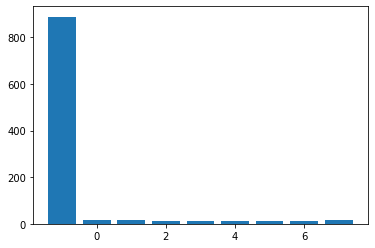

In [15]:
plt.bar(*np.unique(da_optics, return_counts=True))

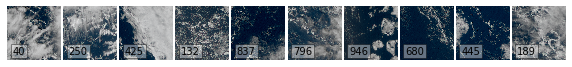

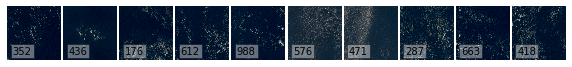

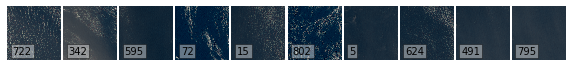

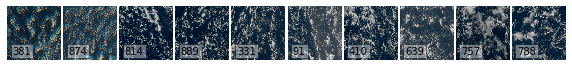

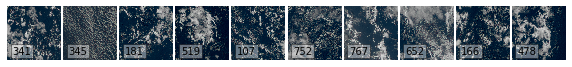

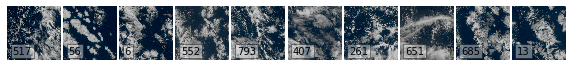

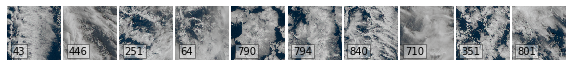

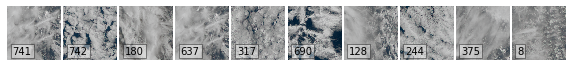

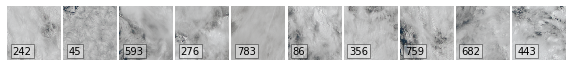

In [16]:
# plot 10 examples from each cluster
triplets = convml_tt.NPMultiImageList.from_folder(da_emb.source_path)

for n in np.unique(da_optics):
    idxs_in_cluster = da_optics.where(da_optics == n, drop=True).tile_id
    idxs = np.random.choice(idxs_in_cluster, min(len(idxs_in_cluster), 10), replace=False)
    convml_tt.interpretation.plots.grid_overview(triplets=triplets, points=idxs, figwidth=10)

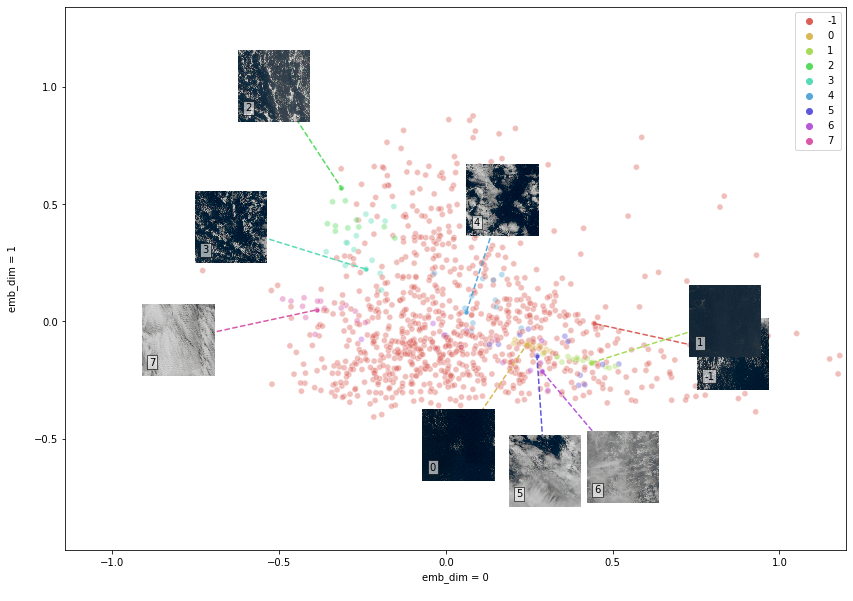

In [17]:
# plot the first two embedding dimensions against each other, annotated with 10 random tiles

fig, ax = plt.subplots(figsize=(14, 10))
x = da_emb.sel(emb_dim=0)
y = da_emb.sel(emb_dim=1)

# construct an array with the index of a tile from each cluster
idxs = np.array([
    da_optics.where(da_optics == n, drop=True).tile_id[0].item() 
    for n in np.unique(da_optics)
])

_ = convml_tt.interpretation.plots.scatter_annotated(x, y, points=idxs, ax=ax, hue=da_optics)

### Questions to look at

1. How are the tiles distributed in the embedding space? Is this what you expected? How could this be modified?

2. Are the distinct clusters in the embedding space which represents quite distinct cloud organisation forms? Describe what they look like if so.

3. How do the different clustering methods differ? What are their strengths and weaknesses?